<html>
  <h1 align="center";> Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones
  </h1>
<hr>
  <h3 align="center";>
  Edición 2022
  </h3>
<hr>
  <h1 align="center";>
  Llamados Atendidos de Violencia Familiar Unificado con Series Temporales
  </h1>
<hr>
  <h2 align="center";>
  Trabajo Práctico 3 - Aprendizaje Supervisado
  </h2>
</html>

## Mentora:
- Isabel Rivadero

## Integrantes:
- Rinaudo, Eleana
- Sulca, Anahí

## Descripción

Los datos corresponden a información recopilada correspondiente a los llamados de todo el país atendidos por los y las profesionales del 137 sobre casos de Violencia Familiar desde Enero de 2017 hasta Febrero del 2022 organizados de manera unificada.

Pueden consultar en:
[Dataset Línea 137 - Victimas de Violencia Familiar](http://datos.jus.gob.ar/dataset/linea-137-victimas-de-violencia-familiar)

El dataset contiene información de:
-  `caso id`
- `descripcion del llamante`
- `género del llamante`
- `tipo de violencia`
- `género de la víctima`
- `cantidad de victimas`
- `cantidad de agresores`
- `género del agresor`
- `relación con la víctima`
- `fecha de la llamada`
- `hora de la llamada`.

Repositorio con los datos listos para procesar:
- [Repositorio Mentoría](https://github.com/IsabelRivadero/ir-mentoria2022)

---
## Objetivo

Este práctico de **Aprendizaje Supervisado** consistirá en
con información precisa que comprende los últimos 5 años de llamadas sobre casos de Violencia Familiar a lo largo de todo el territorio nacional, **entrenar** un modelo de series temporales (no se requiere hacer el análisis propio y más
avanzado de series temporales, sino que se espera un desarrollo
introductorio) para **predecir** comportamientos por días y
horarios(opcionalmente), como así también encontrar tendencias y
comportamientos periódicos.

---
## Consignas:

1. Pasar el código propuesto, a una copia del notebook que venían
trabajando, compartir y subir cambios a un nuevo branch.
2. Usar los datos que obtuvieron luego de aplicar la limpieza que
trabajaron en el práctico anterior.
3. Completar el TP3 usando el código guía que les comparto, y
continuar la experimentación probando con variaciones de parámetros,
hasta obtener la predicción con mejor ajuste a lo que realmente sucedió
y la mejor métrica.
Tener en cuenta las particularidades del intervalo de tiempo que se
desea predecir.
4. Además se les pide realizar todo el procedimiento nuevamente para
otra escala de tiempo (horas, semanas, meses) y las variaciones que
crean necesarias para mejorar los resultados.
5. Investigar y aplicar por lo menos una métrica extra a las que se dan
en el código de ejemplo.
6. Escribir conclusión. Investigar si lo que se observa coincide con algún otro estudio zonal en esa misma época.



<html>
<hr>
  <h1 align="center";>
  Desarrollo
  </h1>
</html>

## Importación de librerías

Importamos la librerías que vamos a utilizar en la Mentoría.

In [ ]:
import warnings
import plotly.express as px
import plotly.graph_objects as go
import io
import datetime as dt
import numpy
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

%matplotlib inline
rcParams['figure.figsize'] = 15, 10
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 20)
sns.set_context("talk")


## Lectura del dataset

Detalle de los llamados de todo el país atendidos por las y los profesionales de la Línea 137, de alcance nacional, sobre casos de Violencia Familiar. La unidad de análisis en este recurso es la víctima principal del caso. Cada fila identifica un llamado y su víctima principal. Corresponde al período comprendido desde Enero de 2017 hasta Febrero del 2022 organizados de manera unificada. Pueden consultar mas información en
[Dataset Línea 137 - Victimas de Violencia Familiar](http://datos.jus.gob.ar/dataset/linea-137-victimas-de-violencia-familiar).

Para poder leer nuestro dataset necesitamos descargarlo desde el [Repositorio de la Mentoría](https://raw.githubusercontent.com/eleanarinaudo/Linea-137-Diplo2022/main/csv/linea137.csv).


In [ ]:
url = "https://raw.githubusercontent.com/eleanarinaudo/Linea-137-Diplo2022/main/Analisis%20Supervisado/data/linea137.csv"
linea137_df = pd.read_csv(url, parse_dates=[0])


Creamos el DataFrame que lo asignamos con la variable `linea137_df` y, además, usamos el método `pd.read_csv` que lee el dataset en Dataframe.


Veamos el contenido del DataFrame `linea137_df` que es el mismo que hicimos en la notebook anterior.

In [ ]:
linea137_df = linea137_df.rename(columns={'Unnamed: 0': 'index'})
linea137_df


,caso_id,llamante_descripcion,llamante_genero,llamante_vinculo_ninios_presentes,violencia_tipo,victima_genero,victima_cantidad,agresor_cantidad,agresor_genero,agresor_relacion_victima,llamado_derivacion,llamado_fecha,llamado_hora,tipo_violencia_Económica,tipo_violencia_Física,tipo_violencia_No-Aplica,tipo_violencia_Otras,tipo_violencia_Psicológica,tipo_violencia_Sexual,fecha_y_hora
0,344552.0,Comisaría,Masculino,Otro/a no Familiar,Física y psicológica,Femenino,3,1,Masculino,Pareja,La víctima no aceptó la intervención del Equip...,2017-01-01,1:37,0,1,0,0,1,0,2017-01-01 01:37:00
1,344553.0,Comisaría,Femenino,Sin datos,Física y psicológica,Femenino,2,1,Masculino,Hermano/a,Llamante solicitó información y/o orientación,2017-01-01,6:42,0,1,0,0,1,0,2017-01-01 06:42:00
2,344554.0,Víctima,Femenino,Madre,Física y psicológica,Femenino,1,1,Masculino,Pareja,Llamante solicitó información y/o orientación,2017-01-01,6:48,0,1,0,0,1,0,2017-01-01 06:48:00
3,344555.0,Víctima,Femenino,No hay niñas/os,Física y psicológica,Femenino,1,1,Masculino,Pareja,Llamante solicitó información y/o orientación,2017-01-01,6:54,0,1,0,0,1,0,2017-01-01 06:54:00
4,344556.0,Comisaría,Masculino,Otro/a no Familiar,Psicológica,Masculino,1,1,Femenino,Madre,Llamante solicitó información y/o orientación,2017-01-01,7:11,0,0,0,0,1,0,2017-01-01 07:11:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37918,443708.0,Vecina/o,Femenino,Otro/a no Familiar,Física y psicológica,Masculino,1,1,Femenino,Madre,Llamante solicitó información y/o orientación,2022-02-28,11:57,0,1,0,0,1,0,2022-02-28 11:57:00
37919,443709.0,Víctima,NS/NC,Sin datos,Física y psicológica,NS/NC,1,2,Masculino,Padre,No se desplazó un Equipo móvil por tratarse de...,2022-02-28,13:08,0,1,0,0,1,0,2022-02-28 13:08:00
37920,443710.0,Víctima,Femenino,No hay niñas/os,Física y psicológica,Femenino,1,1,Masculino,Hijo/a,Llamante solicitó información y/o orientación,2022-02-28,13:30,0,1,0,0,1,0,2022-02-28 13:30:00
37921,443711.0,Familiar,Femenino,No hay niñas/os,Física y psicológica,Femenino,1,1,Masculino,Pareja,Llamante solicitó información y/o orientación,2022-02-28,13:36,0,1,0,0,1,0,2022-02-28 13:36:00


In [ ]:
linea137_df.dtypes


caso_id                              object
llamante_descripcion                 object
llamante_genero                      object
llamante_vinculo_ninios_presentes    object
violencia_tipo                       object
victima_genero                       object
victima_cantidad                      int64
agresor_cantidad                      int64
agresor_genero                       object
agresor_relacion_victima             object
llamado_derivacion                   object
llamado_fecha                        object
llamado_hora                         object
tipo_violencia_Económica              int64
tipo_violencia_Física                 int64
tipo_violencia_No-Aplica              int64
tipo_violencia_Otras                  int64
tipo_violencia_Psicológica            int64
tipo_violencia_Sexual                 int64
fecha_y_hora                         object
dtype: object

Eliminamos las columnas de `caso_id`, `violencia_tipo` y `fecha_y_hora` ya que no es de nuevo interés.

In [ ]:
linea137_df = linea137_df.drop(['violencia_tipo'], axis=1)
linea137_df = linea137_df.drop(['fecha_y_hora'], axis=1)
linea137_df = linea137_df.drop(['caso_id'], axis=1)


Antes de seguir con el análisis, decidimos eliminar las filas que contienen los datos después del 2021-12-31 ya que no tenemos muchos datos del 2022.

In [ ]:
linea137_df["fecha_hora"] = linea137_df.llamado_fecha.astype(
    str) + " " + linea137_df.llamado_hora.astype(str)
linea137_df["fecha_hora"] = pd.to_datetime(
    linea137_df["fecha_hora"], format="%Y-%m-%d %H:%M:%S"
)
linea137_df.fecha_hora.head()


0   2017-01-01 01:37:00
1   2017-01-01 06:42:00
2   2017-01-01 06:48:00
3   2017-01-01 06:54:00
4   2017-01-01 07:11:00
Name: fecha_hora, dtype: datetime64[ns]

In [ ]:
linea137_df["llamado_fecha"] = pd.to_datetime(
    linea137_df["llamado_fecha"], format="%Y-%m-%d")
linea137_df.dtypes


llamante_descripcion                         object
llamante_genero                              object
llamante_vinculo_ninios_presentes            object
victima_genero                               object
victima_cantidad                              int64
agresor_cantidad                              int64
agresor_genero                               object
agresor_relacion_victima                     object
llamado_derivacion                           object
llamado_fecha                        datetime64[ns]
llamado_hora                                 object
tipo_violencia_Económica                      int64
tipo_violencia_Física                         int64
tipo_violencia_No-Aplica                      int64
tipo_violencia_Otras                          int64
tipo_violencia_Psicológica                    int64
tipo_violencia_Sexual                         int64
fecha_hora                           datetime64[ns]
dtype: object

In [ ]:
linea137_df['anio'] = linea137_df['fecha_hora'].dt.year
linea137_df.drop(linea137_df[(linea137_df.anio == 2022)].index, inplace=True)


Agregamos las columnas `mes`, `semana`, `dia` y `dia_semana`

In [ ]:
linea137_df['mes'] = linea137_df['fecha_hora'].dt.month
linea137_df['dia'] = linea137_df['fecha_hora'].dt.day
linea137_df['semana'] = linea137_df['fecha_hora'].dt.week
linea137_df['dia_semana'] = linea137_df['fecha_hora'].dt.weekday


Agregamos las columnas `mes del año` y `semana del año`

In [ ]:
linea137_df['semana_del_anio'] = linea137_df['anio'].astype(
    "str") + "-" + [sem.zfill(2) for sem in linea137_df['dia_semana'].astype("str")]
linea137_df['mes_del_anio'] = linea137_df['anio'].astype(
    "str") + "-" + [mes.zfill(2) for mes in linea137_df['mes'].astype("str")]


Agregamos la columna `hora`

In [ ]:
linea137_df['hora'] = linea137_df['fecha_hora'].dt.strftime('%H')


In [ ]:
linea137_df


,llamante_descripcion,llamante_genero,llamante_vinculo_ninios_presentes,victima_genero,victima_cantidad,agresor_cantidad,agresor_genero,agresor_relacion_victima,llamado_derivacion,llamado_fecha,...,tipo_violencia_Sexual,fecha_hora,anio,mes,dia,semana,dia_semana,semana_del_anio,mes_del_anio,hora
0,Comisaría,Masculino,Otro/a no Familiar,Femenino,3,1,Masculino,Pareja,La víctima no aceptó la intervención del Equip...,2017-01-01,...,0,2017-01-01 01:37:00,2017,1,1,52,6,2017-06,2017-01,01
1,Comisaría,Femenino,Sin datos,Femenino,2,1,Masculino,Hermano/a,Llamante solicitó información y/o orientación,2017-01-01,...,0,2017-01-01 06:42:00,2017,1,1,52,6,2017-06,2017-01,06
2,Víctima,Femenino,Madre,Femenino,1,1,Masculino,Pareja,Llamante solicitó información y/o orientación,2017-01-01,...,0,2017-01-01 06:48:00,2017,1,1,52,6,2017-06,2017-01,06
3,Víctima,Femenino,No hay niñas/os,Femenino,1,1,Masculino,Pareja,Llamante solicitó información y/o orientación,2017-01-01,...,0,2017-01-01 06:54:00,2017,1,1,52,6,2017-06,2017-01,06
4,Comisaría,Masculino,Otro/a no Familiar,Masculino,1,1,Femenino,Madre,Llamante solicitó información y/o orientación,2017-01-01,...,0,2017-01-01 07:11:00,2017,1,1,52,6,2017-06,2017-01,07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36839,Familiar,Femenino,Sin datos,Femenino,1,1,Masculino,Padre,Llamante solicitó información y/o orientación,2021-12-31,...,1,2021-12-31 11:52:00,2021,12,31,52,4,2021-04,2021-12,11
36840,Víctima,Masculino,Padre,Masculino,1,1,Femenino,Ex pareja,Llamante solicitó información y/o orientación,2021-12-31,...,0,2021-12-31 12:59:00,2021,12,31,52,4,2021-04,2021-12,12
36841,Vecina/o,Femenino,Otro/a no Familiar,Femenino,1,2,Masculino,Otro/a conviviente,Llamante solicitó información y/o orientación,2021-12-31,...,0,2021-12-31 16:53:00,2021,12,31,52,4,2021-04,2021-12,16
36842,Víctima,Femenino,No hay niñas/os,Femenino,4,1,Masculino,Hermano/a,Llamante solicitó información y/o orientación,2021-12-31,...,0,2021-12-31 16:58:00,2021,12,31,52,4,2021-04,2021-12,16


## Análisis de valos faltantes

In [ ]:
linea137_df.isna().sum()


llamante_descripcion                 0
llamante_genero                      0
llamante_vinculo_ninios_presentes    0
victima_genero                       0
victima_cantidad                     0
                                    ..
semana                               0
dia_semana                           0
semana_del_anio                      0
mes_del_anio                         0
hora                                 0
Length: 26, dtype: int64


El dataset no tiene valores faltantes por lo que no requiere ningún tipo de imputación.


In [ ]:
linea137 = linea137_df.copy()


## Normalizamos los datos

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

linea137["llamante_descripcion"] = le.fit_transform(
    linea137['llamante_descripcion'])
linea137["llamante_genero"] = le.fit_transform(linea137['llamante_genero'])
linea137["llamante_vinculo_ninios_presentes"] = le.fit_transform(
    linea137['llamante_vinculo_ninios_presentes'])
linea137["llamante_descripcion"] = le.fit_transform(
    linea137['llamante_descripcion'])
linea137["victima_genero"] = le.fit_transform(linea137['victima_genero'])
linea137["agresor_genero"] = le.fit_transform(linea137['agresor_genero'])
linea137["agresor_relacion_victima"] = le.fit_transform(
    linea137['agresor_relacion_victima'])
linea137["llamado_derivacion"] = le.fit_transform(
    linea137['llamado_derivacion'])
linea137.head()


,llamante_descripcion,llamante_genero,llamante_vinculo_ninios_presentes,victima_genero,victima_cantidad,agresor_cantidad,agresor_genero,agresor_relacion_victima,llamado_derivacion,llamado_fecha,...,tipo_violencia_Sexual,fecha_hora,anio,mes,dia,semana,dia_semana,semana_del_anio,mes_del_anio,hora
0,1,1,4,0,3,1,1,11,3,2017-01-01,...,0,2017-01-01 01:37:00,2017,1,1,52,6,2017-06,2017-01,01
1,1,0,7,0,2,1,1,2,4,2017-01-01,...,0,2017-01-01 06:42:00,2017,1,1,52,6,2017-06,2017-01,06
2,9,0,1,0,1,1,1,11,4,2017-01-01,...,0,2017-01-01 06:48:00,2017,1,1,52,6,2017-06,2017-01,06
3,9,0,2,0,1,1,1,11,4,2017-01-01,...,0,2017-01-01 06:54:00,2017,1,1,52,6,2017-06,2017-01,06
4,1,1,4,1,1,1,0,5,4,2017-01-01,...,0,2017-01-01 07:11:00,2017,1,1,52,6,2017-06,2017-01,07


In [ ]:
linea137_df.shape


(36795, 26)

In [ ]:
correlation_matrix = linea137.corr().round(2)
fig = px.imshow(correlation_matrix,
                color_continuous_scale='Viridis',
                text_auto=True,
                aspect="auto")
fig.show()


>**Observación:**
>
> Observamos que hay una relación inversamente lineal entre el tipo de violencia Otras y la violencia tipo Psicológica.


#### Agrupamos por `dia`, `mes` y `semana`

In [ ]:
df_victimas_x_dia = linea137.groupby(['llamado_fecha'], as_index=False).agg({
    'victima_cantidad': 'sum'})
df_victimas_x_dia


,llamado_fecha,victima_cantidad
0,2017-01-01,61
1,2017-01-02,87
2,2017-01-03,56
3,2017-01-04,74
4,2017-01-05,54
...,...,...
1819,2021-12-27,51
1820,2021-12-28,55
1821,2021-12-29,47
1822,2021-12-30,21


In [ ]:
df_victimas_x_mes = linea137.groupby(['mes_del_anio'], as_index=False).agg({
    'victima_cantidad': 'sum'})
df_victimas_x_mes


,mes_del_anio,victima_cantidad
0,2017-01,1648
1,2017-02,1393
2,2017-03,1617
3,2017-04,1309
4,2017-05,1212
...,...,...
55,2021-08,1035
56,2021-09,1044
57,2021-10,938
58,2021-11,986


In [ ]:
df_victimas_x_semana = linea137.groupby(
    ['semana_del_anio'], as_index=False).agg({'victima_cantidad': 'sum'})
df_victimas_x_semana


,semana_del_anio,victima_cantidad
0,2017-00,2333
1,2017-01,2048
2,2017-02,2208
3,2017-03,1906
4,2017-04,1905
...,...,...
30,2021-02,1833
31,2021-03,1743
32,2021-04,1671
33,2021-05,1437


---
### Analizamos la cantidad de casos por cada **Día por año**

Pasamos a formato `datetime`

In [ ]:
df_victimas_x_dia['llamado_fecha'] = pd.to_datetime(
    df_victimas_x_dia['llamado_fecha'])
df_victimas_x_dia.dtypes


llamado_fecha       datetime64[ns]
victima_cantidad             int64
dtype: object

In [ ]:
df_victimas_x_dia.head()


,llamado_fecha,victima_cantidad
0,2017-01-01,61
1,2017-01-02,87
2,2017-01-03,56
3,2017-01-04,74
4,2017-01-05,54


In [ ]:
df_victimas_x_dia.llamado_fecha.value_counts()


2017-01-01    1
2020-05-12    1
2020-05-10    1
2020-05-09    1
2020-05-08    1
             ..
2018-08-28    1
2018-08-27    1
2018-08-26    1
2018-08-25    1
2021-12-31    1
Name: llamado_fecha, Length: 1824, dtype: int64

Evaluamos la cantidad de dias en los años

In [ ]:
df_victimas_x_dia.llamado_fecha.dt.year.value_counts()


2020    366
2017    365
2019    365
2021    365
2018    363
Name: llamado_fecha, dtype: int64

In [ ]:
df_victimas_x_dia['llamado_fecha'] = pd.to_datetime(
    df_victimas_x_dia['llamado_fecha'], format='%Y-%m-%d')


In [ ]:
df_victimas_x_dia.dtypes


llamado_fecha       datetime64[ns]
victima_cantidad             int64
dtype: object

In [ ]:
fig = px.scatter(df_victimas_x_dia, x='llamado_fecha', y='victima_cantidad')
fig.show()


In [ ]:
fig = px.line(df_victimas_x_dia, x="llamado_fecha", y="victima_cantidad")
fig.show()


>**Observación:**
>
> Observamos que hay varios picos.
> - 20 de Febrero del 2017 con 92 casos
> - 12 de Enero del 2017 con 90 casos
> - 7 y 15 de Septiembre del 2020 con 95 casos
>
> A simple vista observamos que los mayores picos fueron en el período del año 2020 hasta 2022, coincidiendo con la pandemia.

---
### Analizamos la cantidad de casos **Meses por año**

Pasamos a formato `datetime`

In [ ]:
df_victimas_x_mes['mes_del_anio'] = pd.to_datetime(
    df_victimas_x_mes['mes_del_anio']).dt.to_period('M')
df_victimas_x_mes.dtypes


mes_del_anio        period[M]
victima_cantidad        int64
dtype: object

In [ ]:
df_victimas_x_mes.head()


,mes_del_anio,victima_cantidad
0,2017-01,1648
1,2017-02,1393
2,2017-03,1617
3,2017-04,1309
4,2017-05,1212


In [ ]:
df_victimas_x_mes.mes_del_anio.value_counts()


2017-01    1
2017-02    1
2019-09    1
2019-10    1
2019-11    1
          ..
2019-01    1
2019-02    1
2019-03    1
2019-04    1
2021-12    1
Freq: M, Name: mes_del_anio, Length: 60, dtype: int64

Evaluamos la cantidad de años en cada mes

In [ ]:
df_victimas_x_mes.mes_del_anio.dt.month.value_counts()


1     5
2     5
3     5
4     5
5     5
6     5
7     5
8     5
9     5
10    5
11    5
12    5
Name: mes_del_anio, dtype: int64

In [ ]:
df_victimas_x_mes.mes_del_anio = df_victimas_x_mes.mes_del_anio.dt.strftime(
    '%Y-%m')


In [ ]:
df_victimas_x_mes.dtypes


mes_del_anio        object
victima_cantidad     int64
dtype: object

In [ ]:
fig = px.scatter(df_victimas_x_mes, x='mes_del_anio', y='victima_cantidad')
fig.show()


In [ ]:
fig = px.line(df_victimas_x_mes, x="mes_del_anio", y="victima_cantidad")
fig.show()


>**Observación:**
>
> Observamos que hay varios picos.
> - Mes de Enero del 2017 con 1648 casos
> - Mes de Marzo del 2017 con 1617 casos
> - Mes de Septiembre del 2020 con 1568 casos
>
> A simple vista observamos que los mayores picos fueron en el período del año 2020 hasta 2022, coincidiendo con la pandemia.

# Aprendizaje Supervisado

Para aplicar modelos de series temporales suponemos que el proceso es invariable en el tiempo, es decir que es **Estacionario**.

Importamos las librerías necesarias

In [ ]:
import statsmodels.api as sm

# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose  # holt winters

# single exponential smoothing
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing


## Descomposición de Series de tiempo 

La librería `statsmodels` tiene una función `season_decompose` que hace la descomposición estacional usando promedio. 

Dada una **serie temporal de datos**, la función se divide en componentes separados de **tendencia**, **estacionalidad** y **residual** (ruido).


### La cantidad de casos por cada **Día por año**

Establecemos como índice `llamado_fecha`

In [ ]:
df_victimas_x_dia = df_victimas_x_dia.set_index('llamado_fecha')
df_victimas_x_dia.head()


,victima_cantidad
llamado_fecha,
2017-01-01,61
2017-01-02,87
2017-01-03,56
2017-01-04,74
2017-01-05,54


El parámetro de tipo de modelo puede ser aditivo o multiplicativo, esto depende de si la amplitud de la estacionalidad de sus datos depende del nivel (media). 

- Si la amplitud de la estacionalidad es independiente del nivel, debe usar el modelo aditivo
- Si la amplitud de la estacionalidad depende del nivel, debe usar el modelo multiplicativo.

En este caso usamos el modelo multiplicativo.

Y utlizamos la frecuencia de 180 ya que es la mitad de observaciones que tiene nuestro modelo a analizar.


In [ ]:
descomposicion_vict_dia = sm.tsa.seasonal_decompose(df_victimas_x_dia['victima_cantidad'],
                                                    model='mult', freq=180)


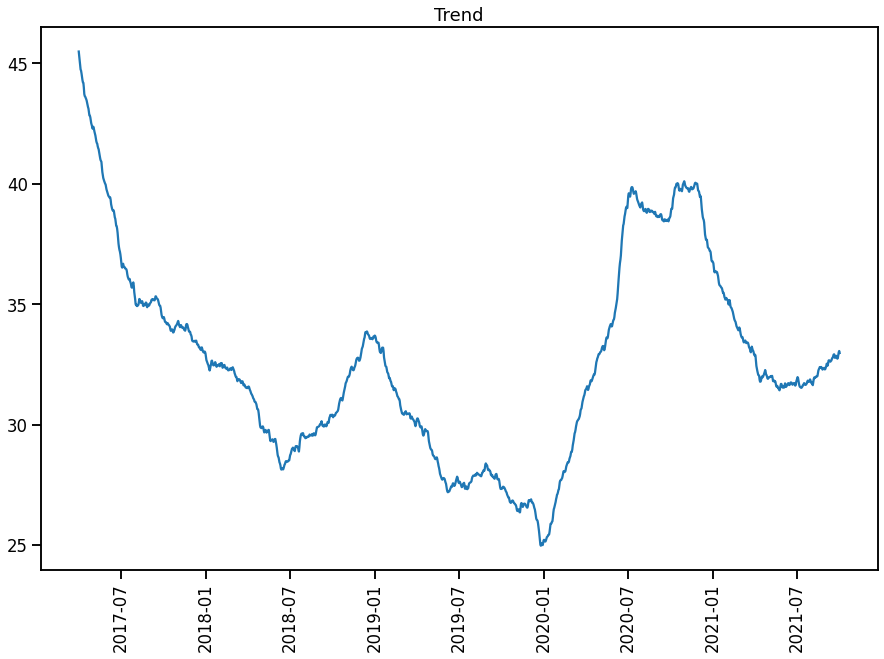

In [ ]:
plt.plot(descomposicion_vict_dia.trend)
plt.xticks(rotation=90)
plt.title("Trend")
plt.show()


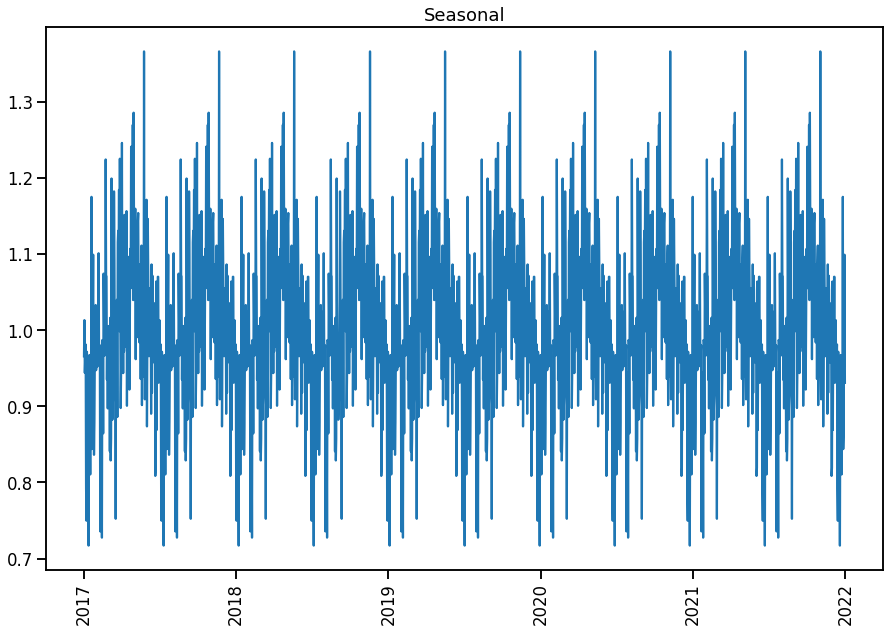

In [ ]:
plt.plot(descomposicion_vict_dia.seasonal)
plt.xticks(rotation=90)
plt.title("Seasonal")
plt.show()


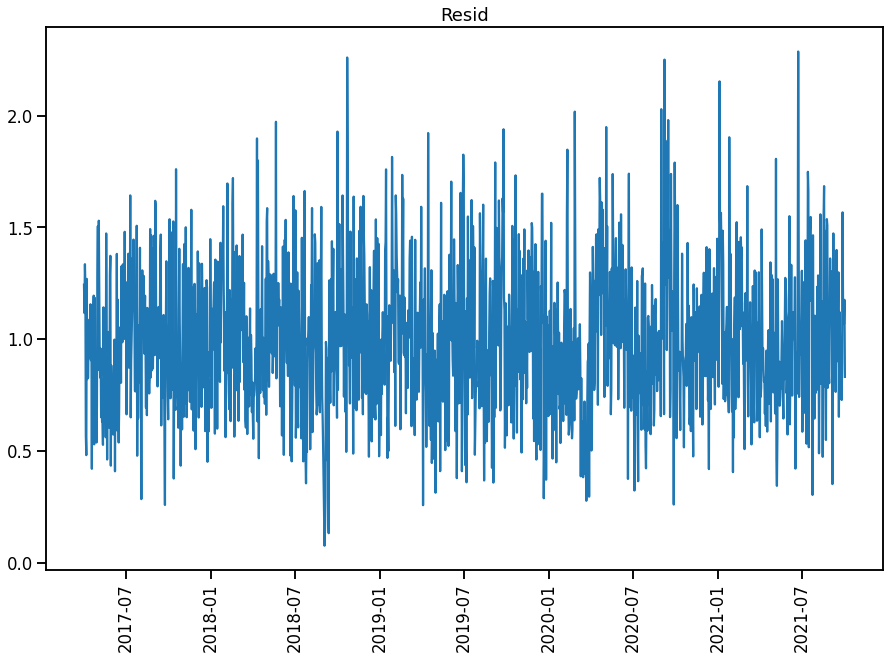

In [ ]:
plt.plot(descomposicion_vict_dia.resid)
plt.xticks(rotation=90)
plt.title("Resid")
plt.show()


### **Por Mes de cada año**

In [ ]:
df_victimas_x_mes.head()


,mes_del_anio,victima_cantidad
0,2017-01,1648
1,2017-02,1393
2,2017-03,1617
3,2017-04,1309
4,2017-05,1212


Lo pasamos de nuevo a `datatime`

In [ ]:
df_victimas_x_mes['mes_del_anio'] = [dt.datetime.strptime(
    i, '%Y-%m') for i in df_victimas_x_mes.mes_del_anio]


Establecemos como índice la fecha `mes_del_anio`

In [ ]:
df_victimas_x_mes = df_victimas_x_mes.set_index('mes_del_anio')
df_victimas_x_mes.head()


,victima_cantidad
mes_del_anio,
2017-01-01,1648
2017-02-01,1393
2017-03-01,1617
2017-04-01,1309
2017-05-01,1212


En este caso usamos el modelo multiplicativo.

Y utlizamos la frecuencia de 6 ya que es la mitad de observaciones que tiene nuestro modelo a analizar.


In [ ]:
descomposicion_vict = sm.tsa.seasonal_decompose(df_victimas_x_mes['victima_cantidad'],
                                                model='mult', freq=6)


Analizamos por separado

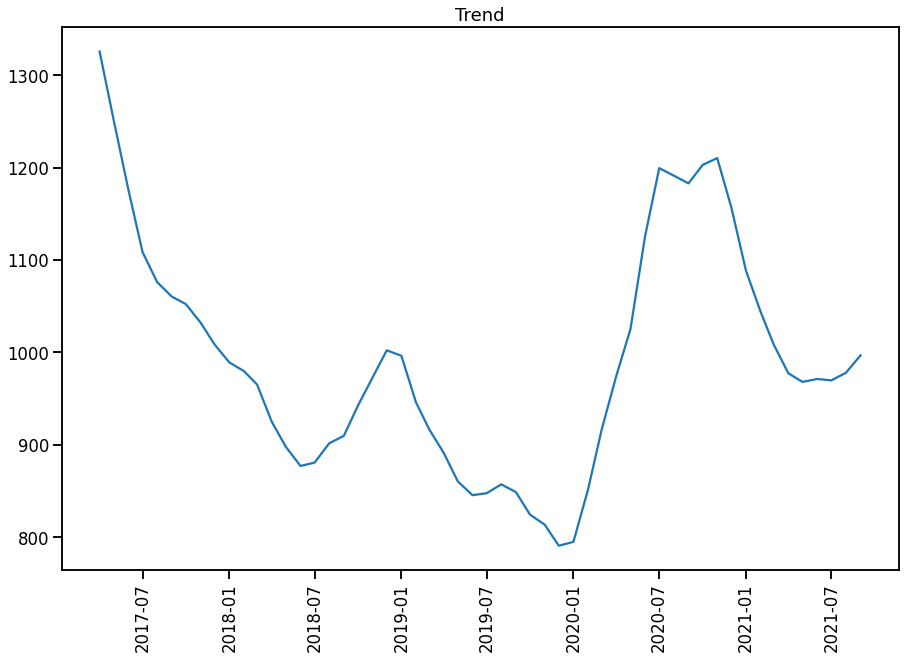

In [ ]:
plt.plot(descomposicion_vict.trend)
plt.xticks(rotation=90)
plt.title("Trend")

plt.show()


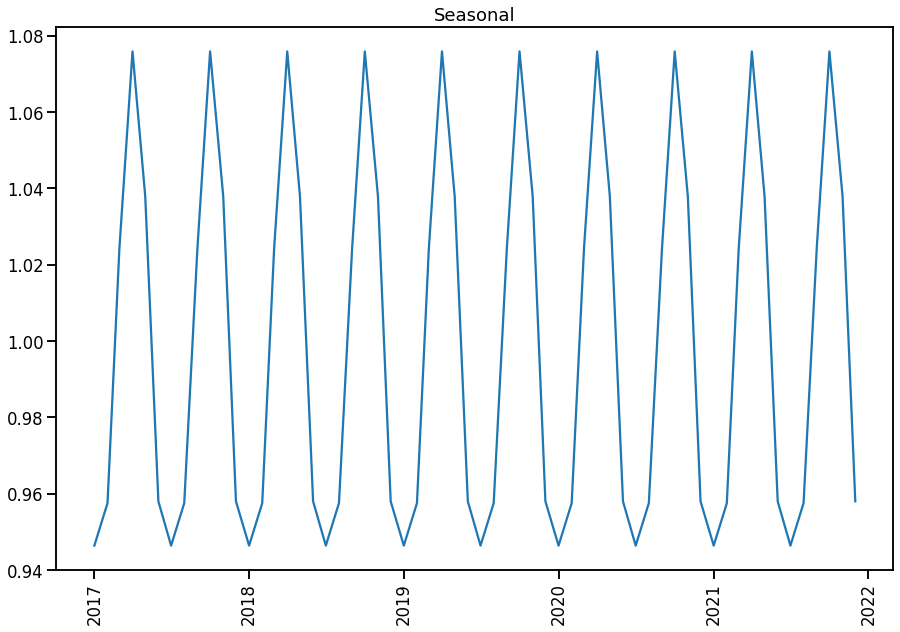

In [ ]:
plt.plot(descomposicion_vict.seasonal)
plt.xticks(rotation=90)
plt.title("Seasonal")
plt.show()


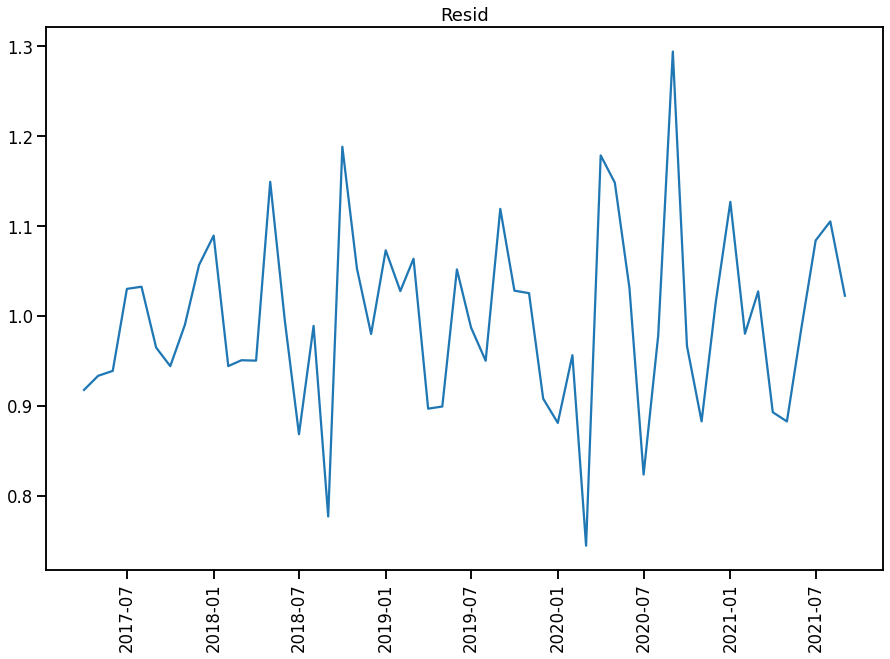

In [ ]:
plt.plot(descomposicion_vict.resid)
plt.xticks(rotation=90)
plt.title("Resid")

plt.show()



<html>
  <hr>
  <h1  align="center";> 
    Holt-Winters Forecasting
  </h1>
  <hr>
</html>



Holt-Winters es un modelo de comportamiento de series de tiempo. La previsión siempre requiere un modelo, y Holt-Winters es una forma de modelar tres aspectos de la serie temporal:
- un valor típico (promedio)
- una pendiente (tendencia) a lo largo del tiempo 
- un patrón cíclico repetitivo (estacionalidad).

<html>
  <h2  align="center";> 
    Exponential smoothing
  </h2>
</html>


El **suavizado exponencial**, Exponential Smothing, es un método de pronóstico de series temporales para datos univariados que se puede ampliar para respaldar datos con una tendencia sistemática o un componente estacional.

### **Por Dia de cada año**

#### **Suavizado exponencial simple**

- Serie temporal básica, solo con un componente.

- La función del suavizado exponencial simple de `statsmodels` realiza las mismas estimaciones que el método de promedios ponderados de pandas.

Establecemos el valor de `alpha` y definimos `m` (Time Period)

In [ ]:
m = 365
alpha = 1/(2*m)


In [ ]:
index = df_victimas_x_dia.index


In [ ]:
steps = 525
train_vict_dia = df_victimas_x_dia[:-steps]
test_vict_dia = df_victimas_x_dia[-steps:]


## Nivel de Suavizado
- **HWES_1** = `None`
- **HWES_2** = $0.8$
- **HWES_3** = $0.2$
- **HWES_4** = $\frac{1}{2*(365)}$


In [ ]:
df_victimas_x_dia['HWES1_1'] = SimpleExpSmoothing(
    df_victimas_x_dia['victima_cantidad']).fit().fittedvalues
df_victimas_x_dia['HWES1_2'] = SimpleExpSmoothing(df_victimas_x_dia['victima_cantidad']).fit(
    smoothing_level=0.8, optimized=False, use_brute=True).fittedvalues
df_victimas_x_dia['HWES1_3'] = SimpleExpSmoothing(df_victimas_x_dia['victima_cantidad']).fit(
    smoothing_level=0.2, optimized=False, use_brute=True).fittedvalues
df_victimas_x_dia['HWES1_4'] = SimpleExpSmoothing(df_victimas_x_dia['victima_cantidad']).fit(
    smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues


In [ ]:
fig = px.line(df_victimas_x_dia, x=index, y=[
              'victima_cantidad', 'HWES1_1', 'HWES1_2', 'HWES1_3', 'HWES1_4'], title='Holt Winters Single Exponential Smoothing')
fig.show()


#### Predicción

In [ ]:
fitted_model_1 = SimpleExpSmoothing(train_vict_dia['victima_cantidad']).fit()
fitted_model_2 = SimpleExpSmoothing(train_vict_dia['victima_cantidad']).fit(
    smoothing_level=0.8, optimized=False, use_brute=True)
fitted_model_3 = SimpleExpSmoothing(train_vict_dia['victima_cantidad']).fit(
    smoothing_level=0.2, optimized=False, use_brute=True)
fitted_model_4 = SimpleExpSmoothing(train_vict_dia['victima_cantidad']).fit(
    smoothing_level=alpha, optimized=False, use_brute=True)


In [ ]:
test_predictions_1 = fitted_model_1.forecast(steps).values
test_predictions_2 = fitted_model_2.forecast(steps).values
test_predictions_3 = fitted_model_3.forecast(steps).values
test_predictions_4 = fitted_model_4.forecast(steps).values


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_dia, test_predictions_1)
Mean_Squared_Error = mean_squared_error(test_vict_dia, test_predictions_1)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


#### Métricas

In [ ]:
print("Sin suavizado")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Sin suavizado
Mean_Absolute_Error: 9.033793784201116
Mean_Squared_Error: 144.85632228727857
Root_Mean_Square_Error: 12.035627207889025


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_dia, test_predictions_2)
Mean_Squared_Error = mean_squared_error(test_vict_dia, test_predictions_2)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Suavizado con 0.8")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Suavizado con 0.8
Mean_Absolute_Error: 10.185296957180697
Mean_Squared_Error: 190.53179518890565
Root_Mean_Square_Error: 13.803325511952025


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_dia, test_predictions_3)
Mean_Squared_Error = mean_squared_error(test_vict_dia, test_predictions_3)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Suavizado con 0.2")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Suavizado con 0.2
Mean_Absolute_Error: 9.224864474996354
Mean_Squared_Error: 145.36756944940564
Root_Mean_Square_Error: 12.056847409227904


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_dia, test_predictions_4)
Mean_Squared_Error = mean_squared_error(test_vict_dia, test_predictions_4)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Suavizado con alpha constante")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Suavizado con alpha constante
Mean_Absolute_Error: 9.31001305753527
Mean_Squared_Error: 146.27484603728686
Root_Mean_Square_Error: 12.094413836035496


>**Observación:**
>
>- Aquí probamos con 4 variantes de suavizado exponencial simple: 
>- La primera variante, no tiene un nivel de suavizado.
> - Para la segunda y tercer variante, elegimos proporcionar explícitamente al modelo el parámetro α= 0.8 y α= 0.2 como nivel de suavizado respectivamente
> - Para el 4to,  el nivel de suavizado es de alpha que hemos asignado, que da como resultado un valor aproximado de 0.001
>- En el gráfico se observa que el primer modelo es el más óptimo, es decir aquel en donde no se definió un nivel de suavizado.
>- Analizando el rendimiento de los modelos, podemos observar los errores cuadráticos medio de los 4 modelos descritos anteriormente, entre los 4 se observa que el error cuadrático medio fue menor para el modelo sin suavizado. 
>Esta función no se ajusta a los valores reales. Ya que:
> - No proyecta tendencias. Podemos ver esto con el próximo modelo: el suavizado exponencial con tendencia, también conocido como doble suavizado exponencial.
>- No reconoce ningún patrón estacional. Resolveremos esto con el modelo de suavizado exponencial triple. 


#### **Serie temporal con 2 componentes, un aditivo y un multiplicativo.**

Cuando el suavizado exponencial simple emplea solo un factor de suavizado (alpha), el suavizado exponencial doble agrega un segundo factor de suavizado (beta) que aborda las tendencias en los datos. Al igual que el factor alpha, los valores para el factor beta están entre cero y uno. El beneficio aquí es que el modelo puede anticipar futuros aumentos o disminuciones donde el modelo de un solo factor solo tendría en cuenta los valores más recientes.

También podemos abordar diferentes tipos de cambio (crecimiento / decadencia) en la tendencia. 

Si una serie temporal muestra una tendencia inclinada en línea recta, se usaría un ajuste aditivo. 

Si la serie temporal muestra una tendencia exponencial (curva), se usaría un ajuste multiplicativo.


In [ ]:
df_victimas_x_dia['HWES2_ADD'] = ExponentialSmoothing(
    df_victimas_x_dia['victima_cantidad'], trend='add').fit().fittedvalues
df_victimas_x_dia['HWES2_MUL'] = ExponentialSmoothing(
    df_victimas_x_dia['victima_cantidad'], trend='mul').fit().fittedvalues


In [ ]:
fig = px.line(df_victimas_x_dia, x=df_victimas_x_dia.index, y=[
              'victima_cantidad', 'HWES2_ADD', 'HWES2_MUL'], title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend')
fig.show()


>**Observación:**
>
>El modelo de suavizado exponencial doble se utiliza para datos de series de tiempo sin estacionalidad, pero con una tendencia. Se admiten tendencias adictivas (lineales) y multiplicativas (exponenciales).
>
>En el gráfico de la cantidad de víctimas por día en cada año,  se observa que la tendencia multiplicativa se ajusta mejor a los datos reales.


## Predicción

In [ ]:
fitted_model_add = ExponentialSmoothing(
    train_vict_dia['victima_cantidad'], trend='add').fit()
fitted_model_mul = ExponentialSmoothing(
    train_vict_dia['victima_cantidad'], trend='mul').fit()


In [ ]:
test_predictions_1 = fitted_model_add.forecast(steps).values
test_predictions_2 = fitted_model_mul.forecast(steps).values


#### Métricas

In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_dia, test_predictions_1)
Mean_Squared_Error = mean_squared_error(test_vict_dia, test_predictions_1)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Tendencia Aditiva")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Tendencia Aditiva
Mean_Absolute_Error: 100.48994839159728
Mean_Squared_Error: 13564.528095474989
Root_Mean_Square_Error: 116.46685406361325


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_dia, test_predictions_2)
Mean_Squared_Error = mean_squared_error(test_vict_dia, test_predictions_2)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Tendencia Multiplicativa")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Tendencia Multiplicativa
Mean_Absolute_Error: 11.69961634958431
Mean_Squared_Error: 232.27132224230044
Root_Mean_Square_Error: 15.24045019815033


>**Observación:**
>
>- Analizando las métricas, podemos observar los errores de los 2 tipos de tendencia y  se observa que el error cuadrático medio fue menor cuando la tendencia es multiplicativa. 
>
>- El suavizado exponencial doble está un paso por encima del suavizado exponencial simple, ya que permite que los datos de la serie temporal tengan un componente de tendencia, aún así sigue siendo incapaz de hacer frente a los datos estacionales.

#### Suavizado Exponencial Triple

Suavizado exponencial triple o Holt-Winters, añade soporte para la **tendencia** y la **estacionalidad**.


In [ ]:
df_victimas_x_dia['HWES3_ADD'] = ExponentialSmoothing(
    df_victimas_x_dia['victima_cantidad'], trend='add', seasonal='add', seasonal_periods=365).fit().fittedvalues
df_victimas_x_dia['HWES3_MUL'] = ExponentialSmoothing(
    df_victimas_x_dia['victima_cantidad'], trend='mul', seasonal='mul', seasonal_periods=365).fit().fittedvalues
df_victimas_x_dia['HWES3_A_M'] = ExponentialSmoothing(
    df_victimas_x_dia['victima_cantidad'], trend='add', seasonal='mul', seasonal_periods=365).fit().fittedvalues
df_victimas_x_dia['HWES3_M_A'] = ExponentialSmoothing(
    df_victimas_x_dia['victima_cantidad'], trend='mul', seasonal='add', seasonal_periods=365).fit().fittedvalues


In [ ]:
fig = px.line(df_victimas_x_dia, x=df_victimas_x_dia.index, y=['victima_cantidad', 'HWES3_ADD', 'HWES3_MUL', 'HWES3_A_M',
              'HWES3_M_A'], title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')
fig.show()


>**Observación:**
>
>- En el gráfico se observa  que para la cantidad de víctimas por día de cada año, el modelo que mejor se aproxima a los datos reales es cuando la tendencia es aditiva y la estacionalidad es multiplicativa.


#### Predicción

In [ ]:
fitted_model_add_add = ExponentialSmoothing(
    train_vict_dia['victima_cantidad'], trend='add', seasonal='add', seasonal_periods=365).fit()
fitted_model_mul_mul = ExponentialSmoothing(
    train_vict_dia['victima_cantidad'], trend='mul', seasonal='mul', seasonal_periods=365).fit()


In [ ]:
fitted_model_add_mul = ExponentialSmoothing(
    train_vict_dia['victima_cantidad'], trend='add', seasonal='mul', seasonal_periods=365).fit()
fitted_model_mul_add = ExponentialSmoothing(
    train_vict_dia['victima_cantidad'], trend='mul', seasonal='add', seasonal_periods=365).fit()


In [ ]:
test_predictions_1 = fitted_model_add_add.forecast(steps).values
test_predictions_2 = fitted_model_mul_add.forecast(steps).values
test_predictions_3 = fitted_model_add_mul.forecast(steps).values
test_predictions_4 = fitted_model_mul_add.forecast(steps).values


#### Métricas

In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_dia, test_predictions_1)
Mean_Squared_Error = mean_squared_error(test_vict_dia, test_predictions_1)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Tendencia Aditiva Estancionaria Aditiva")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Tendencia Aditiva Estancionaria Aditiva
Mean_Absolute_Error: 12.660875442609655
Mean_Squared_Error: 241.26662999141442
Root_Mean_Square_Error: 15.532759896148992


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_dia, test_predictions_2)
Mean_Squared_Error = mean_squared_error(test_vict_dia, test_predictions_2)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Tendencia Multiplicativa Estancionaria Multiplicativa")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Tendencia Multiplicativa Estancionaria Multiplicativa
Mean_Absolute_Error: 16.037100739504453
Mean_Squared_Error: 401.23757271854384
Root_Mean_Square_Error: 20.030915423877758


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_dia, test_predictions_3)
Mean_Squared_Error = mean_squared_error(test_vict_dia, test_predictions_3)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Tendencia Aditiva Estancionaria Multiplicativa")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Tendencia Aditiva Estancionaria Multiplicativa
Mean_Absolute_Error: 12.90649914879225
Mean_Squared_Error: 253.64006552654607
Root_Mean_Square_Error: 15.926081298503599


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_dia, test_predictions_4)
Mean_Squared_Error = mean_squared_error(test_vict_dia, test_predictions_4)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Tendencia Multiplicativa Estancionaria Aditiva")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Tendencia Multiplicativa Estancionaria Aditiva
Mean_Absolute_Error: 16.037100739504453
Mean_Squared_Error: 401.23757271854384
Root_Mean_Square_Error: 20.030915423877758


>**Observación:**
>
>- De acuerdo a las métricas, el error cuadrático medio tiene mejor ajuste cuando la tendencia y la estacionalidad son aditivas.


### **Por Mes de cada año**

#### **Suavizado exponencial simple**

Serie temporal básica, solo con una componente.

La función del suavizado exponencial simple de `statsmodels` realiza las mismas estimaciones que el método de promedios ponderados de pandas.

Establecemos el valor de `alpha` y definimos `m` (Time Period)

## Nivel de Suavizado
- **HWES_1** = `None`
- **HWES_2** = $0.8$
- **HWES_3** = $0.2$
- **HWES_4** = $\frac{1}{2*(12)}$

In [ ]:
m = 12
alpha = 1/(2*m)


In [ ]:
steps = 18
train_vict_mes = df_victimas_x_mes[:-steps]
test_vict_mes = df_victimas_x_mes[-steps:]


In [ ]:
df_victimas_x_mes['HWES1_1'] = SimpleExpSmoothing(
    df_victimas_x_mes['victima_cantidad']).fit().fittedvalues
df_victimas_x_mes['HWES1_2'] = SimpleExpSmoothing(df_victimas_x_mes['victima_cantidad']).fit(
    smoothing_level=0.8, optimized=False, use_brute=True).fittedvalues
df_victimas_x_mes['HWES1_3'] = SimpleExpSmoothing(df_victimas_x_mes['victima_cantidad']).fit(
    smoothing_level=0.2, optimized=False, use_brute=True).fittedvalues
df_victimas_x_mes['HWES1_4'] = SimpleExpSmoothing(df_victimas_x_mes['victima_cantidad']).fit(
    smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues


In [ ]:
fig = px.line(df_victimas_x_mes, x=df_victimas_x_mes.index, y=[
              'victima_cantidad', 'HWES1_1', 'HWES1_2', 'HWES1_3', 'HWES1_4'], title='Holt Winters Single Exponential Smoothing')
fig.show()


>**Observación:**
>
>- Observamos en el gráfico que los resultados no se ajustan a los valores reales, sin embargo una vez más el mejor modelo fue el del nivel sin suavizado


#### Predición

In [ ]:
fitted_model_1 = SimpleExpSmoothing(train_vict_mes['victima_cantidad']).fit()
fitted_model_2 = SimpleExpSmoothing(train_vict_mes['victima_cantidad']).fit(
    smoothing_level=0.8, optimized=False, use_brute=True)
fitted_model_3 = SimpleExpSmoothing(train_vict_mes['victima_cantidad']).fit(
    smoothing_level=0.2, optimized=False, use_brute=True)
fitted_model_4 = SimpleExpSmoothing(train_vict_mes['victima_cantidad']).fit(
    smoothing_level=alpha, optimized=False, use_brute=True)


In [ ]:
test_predictions_1 = fitted_model_1.forecast(steps).values
test_predictions_2 = fitted_model_2.forecast(steps).values
test_predictions_3 = fitted_model_3.forecast(steps).values
test_predictions_4 = fitted_model_4.forecast(steps).values


#### Métricas

In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_mes, test_predictions_1)
Mean_Squared_Error = mean_squared_error(test_vict_mes, test_predictions_1)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Sin Suavizado")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Sin Suavizado
Mean_Absolute_Error: 135.8969099448221
Mean_Squared_Error: 28735.142478015317
Root_Mean_Square_Error: 169.51443147418252


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_mes, test_predictions_2)
Mean_Squared_Error = mean_squared_error(test_vict_mes, test_predictions_2)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Alpha con 0.8")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Alpha con 0.8
Mean_Absolute_Error: 134.90677872914785
Mean_Squared_Error: 28526.579622010166
Root_Mean_Square_Error: 168.8981338618345


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_mes, test_predictions_3)
Mean_Squared_Error = mean_squared_error(test_vict_mes, test_predictions_3)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Alpha con 0.2")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Alpha con 0.2
Mean_Absolute_Error: 113.62833320106262
Mean_Squared_Error: 30765.16704181061
Root_Mean_Square_Error: 175.4000200735753


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_mes, test_predictions_4)
Mean_Squared_Error = mean_squared_error(test_vict_mes, test_predictions_4)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Alpha constante")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Alpha constante
Mean_Absolute_Error: 109.6042960409564
Mean_Squared_Error: 23752.98986364691
Root_Mean_Square_Error: 154.12005016754605


>**Observación:**
>
>- En las métricas podemos observar que el error cuadrático medio fue menor en el modelo con el nivel de suavizado de α = 1/(2*12). 
>
>- El método de suavizado exponencial simple no es óptimo para la predicción ya que no contiene tendencia ni estacionalidad. 


#### **Serie temporal con 2 componentes, un aditivo y un multiplicativo.**

Cuando el suavizado exponencial simple emplea solo un factor de suavizado (alpha), el suavizado exponencial doble agrega un segundo factor de suavizado (beta) que aborda las tendencias en los datos. Al igual que el factor alpha, los valores para el factor beta están entre cero y uno. El beneficio aquí es que el modelo puede anticipar futuros aumentos o disminuciones donde el modelo de un solo factor solo tendría en cuenta los valores más recientes.

También podemos abordar diferentes tipos de cambio (crecimiento / decadencia) en la tendencia. 

Si una serie temporal muestra una tendencia inclinada en línea recta, se usaría un ajuste aditivo. 

Si la serie temporal muestra una tendencia exponencial (curva), se usaría un ajuste multiplicativo.


In [ ]:
df_victimas_x_mes['HWES2_ADD'] = ExponentialSmoothing(
    df_victimas_x_mes['victima_cantidad'], trend='add').fit().fittedvalues
df_victimas_x_mes['HWES2_MUL'] = ExponentialSmoothing(
    df_victimas_x_mes['victima_cantidad'], trend='mul').fit().fittedvalues


In [ ]:
fig = px.line(df_victimas_x_mes, x=df_victimas_x_mes.index, y=[
              'victima_cantidad', 'HWES2_ADD', 'HWES2_MUL'], title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend')
fig.show()


>**Observación:**
>
>- En el gráfico de la cantidad de víctimas por día en cada año,  se observa que la tendencia multiplicativa se ajusta mejor a los datos reales.

#### Predicción

In [ ]:
fitted_model_add = ExponentialSmoothing(
    train_vict_mes['victima_cantidad'], trend='add').fit()
fitted_model_mul = ExponentialSmoothing(
    train_vict_mes['victima_cantidad'], trend='mul').fit()


In [ ]:
test_predictions_1 = fitted_model_add.forecast(steps).values
test_predictions_2 = fitted_model_mul.forecast(steps).values


#### Métricas

In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_mes, test_predictions_1)
Mean_Squared_Error = mean_squared_error(test_vict_mes, test_predictions_1)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Tendencia Aditiva")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Tendencia Aditiva
Mean_Absolute_Error: 97.52587792564685
Mean_Squared_Error: 20205.8192249645
Root_Mean_Square_Error: 142.1471745233246


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_mes, test_predictions_2)
Mean_Squared_Error = mean_squared_error(test_vict_mes, test_predictions_2)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Tendencia Multiplicativa")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Tendencia Multiplicativa
Mean_Absolute_Error: 902.6217444572748
Mean_Squared_Error: 1119103.180296551
Root_Mean_Square_Error: 1057.8767320895904


>**Observación:**
>
>- Analizando las métricas, podemos observar los errores de los 2 tipos de tendencia y  se observa que el error cuadrático medio fue menor cuando la tendencia es multiplicativa. 

#### Suavizado Exponencial Triple

Suavizado exponencial triple o Holt-Winters, añade soporte para la **tendencia** y la **estacionalidad**.

In [ ]:
df_victimas_x_mes['HWES3_ADD'] = ExponentialSmoothing(
    df_victimas_x_mes['victima_cantidad'], trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues
df_victimas_x_mes['HWES3_MUL'] = ExponentialSmoothing(
    df_victimas_x_mes['victima_cantidad'], trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues
df_victimas_x_mes['HWES3_A_M'] = ExponentialSmoothing(
    df_victimas_x_mes['victima_cantidad'], trend='add', seasonal='mul', seasonal_periods=12).fit().fittedvalues
df_victimas_x_mes['HWES3_M_A'] = ExponentialSmoothing(
    df_victimas_x_mes['victima_cantidad'], trend='mul', seasonal='add', seasonal_periods=12).fit().fittedvalues


In [ ]:
fig = px.line(df_victimas_x_mes, x=df_victimas_x_mes.index, y=['victima_cantidad', 'HWES3_ADD', 'HWES3_MUL', 'HWES3_A_M',
              'HWES3_M_A'], title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')
fig.show()


>**Observación:**
>
>- En el gráfico se observa  que para la cantidad de víctimas por día de cada año, el modelo que mejor se aproxima a los datos reales es cuando la tendencia es aditiva y la estacionalidad es multiplicativa.

#### Predicción

In [ ]:
fitted_model_add_add = ExponentialSmoothing(
    train_vict_mes['victima_cantidad'], trend='add', seasonal='add', seasonal_periods=12).fit()
fitted_model_mul_mul = ExponentialSmoothing(
    train_vict_mes['victima_cantidad'], trend='mul', seasonal='mul', seasonal_periods=12).fit()


In [ ]:
fitted_model_add_mul = ExponentialSmoothing(
    train_vict_mes['victima_cantidad'], trend='add', seasonal='mul', seasonal_periods=12).fit()
fitted_model_mul_add = ExponentialSmoothing(
    train_vict_mes['victima_cantidad'], trend='mul', seasonal='add', seasonal_periods=12).fit()


In [ ]:
test_predictions_1 = fitted_model_add_add.forecast(steps).values
test_predictions_2 = fitted_model_mul_add.forecast(steps).values
test_predictions_3 = fitted_model_add_mul.forecast(steps).values
test_predictions_4 = fitted_model_mul_add.forecast(steps).values


####  Métricas

In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_mes, test_predictions_1)
Mean_Squared_Error = mean_squared_error(test_vict_mes, test_predictions_1)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Tendencia Aditiva Estancionaria Aditiva")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Tendencia Aditiva Estancionaria Aditiva
Mean_Absolute_Error: 278.4827619923342
Mean_Squared_Error: 115297.24370543809
Root_Mean_Square_Error: 339.55447825855293


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_mes, test_predictions_2)
Mean_Squared_Error = mean_squared_error(test_vict_mes, test_predictions_2)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Tendencia Multiplicativa Estancionaria Multiplicativa")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Tendencia Multiplicativa Estancionaria Multiplicativa
Mean_Absolute_Error: 359.988464871906
Mean_Squared_Error: 183949.92301773053
Root_Mean_Square_Error: 428.8938365350224


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_mes, test_predictions_3)
Mean_Squared_Error = mean_squared_error(test_vict_mes, test_predictions_3)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Tendencia Aditiva Estancionaria Multiplicativa")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Tendencia Aditiva Estancionaria Multiplicativa
Mean_Absolute_Error: 152.33380782132332
Mean_Squared_Error: 39189.62509123309
Root_Mean_Square_Error: 197.96369639717554


In [ ]:
Mean_Absolute_Error = mean_absolute_error(test_vict_mes, test_predictions_4)
Mean_Squared_Error = mean_squared_error(test_vict_mes, test_predictions_4)
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print("Tendencia Multiplicativa Estancionaria Aditiva")
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Tendencia Multiplicativa Estancionaria Aditiva
Mean_Absolute_Error: 359.988464871906
Mean_Squared_Error: 183949.92301773053
Root_Mean_Square_Error: 428.8938365350224


>**Observación:**
>
>- De acuerdo a las métricas, el error cuadrático medio tiene mejor ajuste cuando la tendencia es aditiva y la estacionalidad es multiplicativa coincidiendo con el análisis del gráfico.

---
## Predicción


### **Por Día de cada año**

Se utilizan los últimos 524 días, un 20% del dataset, como conjunto de test para evaluar la capacidad predictiva del modelo.

In [ ]:
steps = 524
train_vict_dia = df_victimas_x_dia[:-steps]
test_vict_dia = df_victimas_x_dia[-steps:]


In [ ]:
fitted_model = ExponentialSmoothing(
    train_vict_dia['victima_cantidad'], trend='add', seasonal='add', seasonal_periods=365).fit()


In [ ]:
test_predictions = fitted_model.forecast(steps)


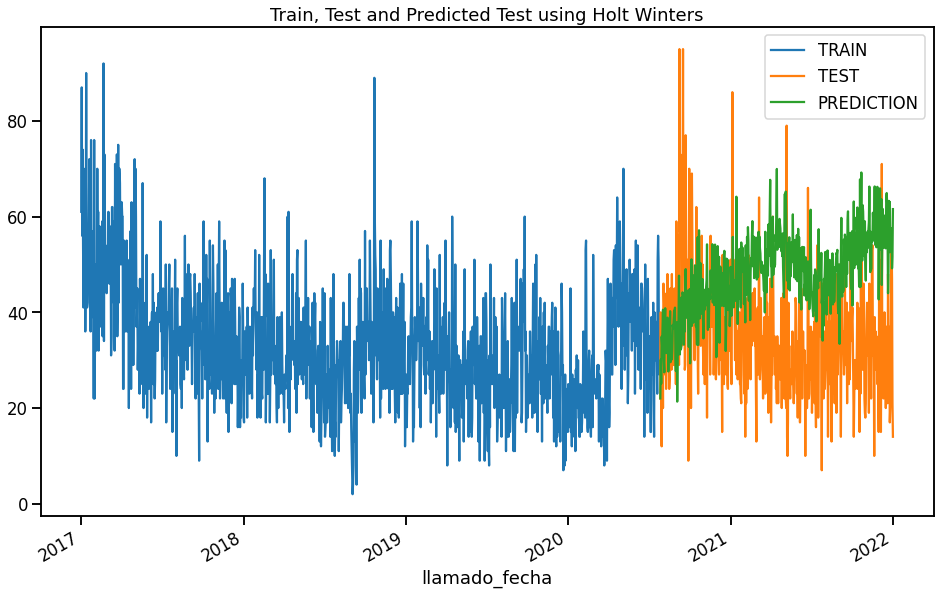

In [ ]:
train_vict_dia['victima_cantidad'].plot(legend=True, label='TRAIN')
test_vict_dia['victima_cantidad'].plot(
    legend=True, label='TEST', figsize=(16, 10))
test_vict_dia['test_pred'] = test_predictions.values
test_vict_dia['test_pred'].plot(legend=True, label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')


>**Observación:**
>
> Según la observación del gráfico, para los últimos 524 días la predicción de ese perído señala una disminución de los casos pero a comparación del test, no fue así.
>
> En ese período de tiempo hubo varios picos de casos, pero en la predicción para ese último período de tiempo los casos disminuyeron.
>
> 
> En la segunda mitad del 2020 hubo un pico marcado que puede deberse a la cantidad de tiempo que las denunciantes incrementaron el tiempo compartido con sus victimarios debido a la pandemia. Esto coincide con las diversas publicaciones al respecto del fuerte incremento de casos de violencia de genero denunciados en el primer año de la pandemia. Sin embargo luego de esto se continuo la tendencia previa, pero sin una disminución. Esto se puede justificar por la pandemia y las condiciones excepcionales de ese período de tiempo. Sin embargo aunque las predicciones no se ajusten a lo que sucedió, es interesante analizarlo y ver que se confirma tambien con nuestro tipo de datos la tendencia global.


### **Por Mes de cada año**

Se utilizan los últimos 18 meses como conjunto de test para evaluar la capacidad predictiva del modelo.

In [ ]:
steps = 18
train_vict_mes = df_victimas_x_mes[:-steps]
test_vict_mes = df_victimas_x_mes[-steps:]


In [ ]:
fitted_model = ExponentialSmoothing(
    train_vict_mes['victima_cantidad'], trend='add', seasonal='mul', seasonal_periods=12).fit()


In [ ]:
test_predictions = fitted_model.forecast(steps)


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

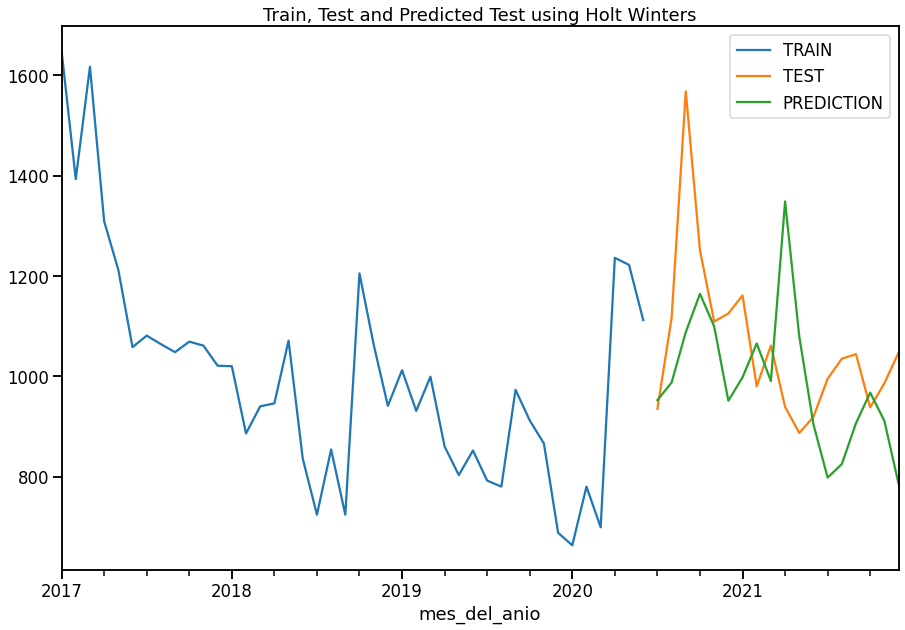

In [ ]:
train_vict_mes['victima_cantidad'].plot(legend=True, label='TRAIN')
test_vict_mes['victima_cantidad'].plot(legend=True, label='TEST')
test_vict_mes['test_pred'] = test_predictions.values
test_vict_mes['test_pred'].plot(legend=True, label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')


>**Observación:**
>
> Según la observación del gráfico, para los últimos 18 meses la predicción de ese perído señala una disminución de los casos a comparación del test.
>
> En ese período de tiempo hubo varios picos de casos, pero en la predicción para ese último período de tiempo los casos disminuyeron aunque hay varios puntos de intersección en el último período.
>



## Test vs Predicción

Analizamos los dos ultimos años

### **Por Día de cada año**

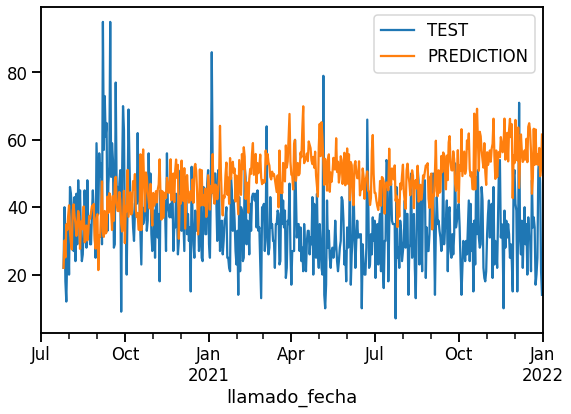

In [ ]:
test_vict_dia['victima_cantidad'].plot(
    legend=True, label='TEST', figsize=(9, 6))
test_vict_dia['test_pred'].plot(legend=True, label='PREDICTION', xlim=[
                                '2020-07', '2022-01-01'])


### **Por Mes de cada año**

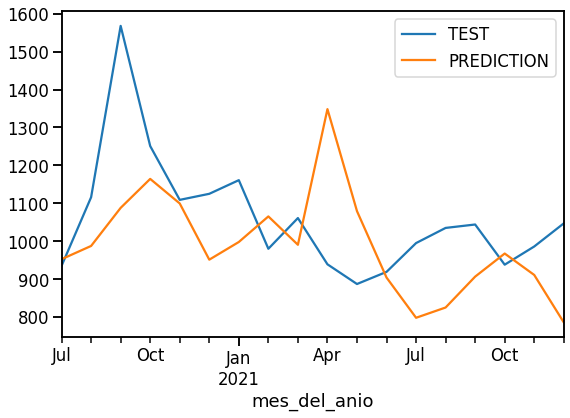

In [ ]:
test_vict_mes['victima_cantidad'].plot(
    legend=True, label='TEST', figsize=(9, 6))
test_vict_mes['test_pred'].plot(
    legend=True, label='PREDICTION', xlim=['2020-07', '2021-12'])


# Metricas de evaluación

Para analizar el rendimiento del modelo tendremos en cuenta:

- MAE(Mean Absolute Error)

- MSE(Mean Squared Error) 

como métricas. 

### Por Dia

Analizamos si existen valores nulos

In [ ]:
test_vict_dia['test_pred'].isna().sum()


0

In [ ]:
Mean_Absolute_Error = mean_absolute_error(
    test_vict_dia['victima_cantidad'], test_vict_dia['test_pred'])
Mean_Squared_Error = mean_squared_error(
    test_vict_dia['victima_cantidad'], test_vict_dia['test_pred'])
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Mean_Absolute_Error: 17.102260131924524
Mean_Squared_Error: 416.58521621797684
Root_Mean_Square_Error: 20.41041930529544


### Por Mes

Analizamos si existen valores nulos

In [ ]:
test_vict_mes['test_pred'].isna().sum()


0

In [ ]:
Mean_Absolute_Error = mean_absolute_error(
    test_vict_mes['victima_cantidad'], test_vict_mes['test_pred'])
Mean_Squared_Error = mean_squared_error(
    test_vict_mes['victima_cantidad'], test_vict_mes['test_pred'])
Root_Mean_Square_Error = math.sqrt(Mean_Squared_Error)


In [ ]:
print('Mean_Absolute_Error:', Mean_Absolute_Error)
print('Mean_Squared_Error:', Mean_Squared_Error)
print('Root_Mean_Square_Error:', Root_Mean_Square_Error)


Mean_Absolute_Error: 152.33380782132332
Mean_Squared_Error: 39189.62509123309
Root_Mean_Square_Error: 197.96369639717554


>**Observación:**
>
> - El **error absoluto medio**  es una cantidad que se utiliza para medir qué tan cerca están las predicciones de los resultados. En este caso el error nos da muy lejanos al esperado.
>
> - El **error cuadrático medio** (RMSE) : RMSE es una regla de puntuación cuadrática que también mide la magnitud promedio del error. Es la raíz cuadrada del promedio de las diferencias al cuadrado entre la predicción y la observación real.
>
> - Observamos que el MAE es menor que el RMSE donde ambas métricas pueden variar de 0 a infinito y son indiferentes a la dirección de los errores. Son puntajes orientados negativamente, lo que significa que los valores más bajos son mejores.
>
>- En el caso de **Dia por Año**, los resultados son más optimistas a comparación de **Mes por Año** ya que está muy alejado al 0. Esto puede deberse a los valores atípicos o picos que hubo en ese período de tiempo.
>



<html>
  <hr>
  <h1  align="center";> 
    Conclusión
  </h1>
  <hr>
</html>


- El modelo no es el mejor para hacer predicciones ya que tiene un comportamiento no estacionario debido a las variaciones en el tiempo. Además, para que sea estacionario, no debe cambiar ni la amplitud, frecuencia y tendencia con el paso del tiempo

- El modelo elegido no es bueno para predecir debido al evento extraordinario que se dio en los años 2020 y 2021.

- De acuerdo al análisis que se realizó, se puede concluir en que el modelo que toma la cantidad de llamadas por día, tuvo una prediccion más aproximada que el modelo que toma la cantidad de llamados por mes. 

- En la segunda mitad del 2020 hubo un pico marcado que puede deberse al incremento del tiempo compartido de las víctimas con sus agresores por la pandemia. Esto coincide con las diversas publicaciones al respecto, que indican el fuerte incremento de las denuncias de violencia de género en el primer año de la pandemia. Además de la pandemia esto se puede justificar por otras condiciones excepcionales que se dieron en ese período de tiempo. Sin embargo, aunque las predicciones no se ajusten a lo que sucedió, es interesante analizarlo y ver que se confirma también con nuestro tipo de datos la tendencia global.

- Se realizó una investigación para observar si lo que se observa coincide con algún otro estudio en esa misma época. Para ellos se busco en primer lugar, noticias relacionadas a la cantidad de llamados realizados para el año 2020 en la provincia de Córdoba, donde la cantidad de llamadas aumentó un promedio de 300 llamadas diarias.  [Cuarentena: hubo más de 5 mil llamadas por violencia familiar y de género en Córdoba](https://www.lavoz.com.ar/ciudadanos/cuarentena-hubo-mas-de-5-mil-llamadas-por-violencia-familiar-y-de-genero-en-cordoba/
)
- Esto puede observarse en el análisis que tomó a la cantidad de llamados por mes, en la que para el año 2021, la cantidad de llamados aumentó consideralemente. Para este caso, la predicción brindo valores mucho más elevados de los que realmente fueron.

- En el caso de **Dia por Año**, los resultados MAE y RMSE son más optimistas a comparación de **Mes por Año** ya que está muy alejado al 0. Esto puede deberse a los valores atípicos o picos que hubo en ese período de tiempo.
